# Falcons.ai Image labeling using Microsoft Phi-3-Vision
### phi3 env
### [The microsoft/Phi-3-vision-128k-instruct model](https://huggingface.co/microsoft/Phi-3-vision-128k-instruct)

## Use Case:
### Tagging a large volume of images in a specific directory.

In [1]:
import os
import glob
import time
import torch
import textwrap
import warnings
from PIL import Image 
# Suppress all warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from transformers import AutoProcessor 
from transformers import AutoModelForCausalLM 
from IPython.display import display, Markdown, Latex, JSON

## Check Cuda specs

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Apr_17_19:19:55_PDT_2024
Cuda compilation tools, release 12.5, V12.5.40
Build cuda_12.5.r12.5/compiler.34177558_0


In [3]:
# from huggingface_hub import notebook_login
# notebook_login()

In [4]:
def Image_desc(image_path,prompt='Describe this image in excruciating detail'):

    ## If you have not downloaded the model:
    # model_id = "microsoft/Phi-3-vision-128k-instruct" 
    # model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto", _attn_implementation='flash_attention_2') # use _attn_implementation='eager' to disable flash attention

    # I have downloaded the model to a sub-directory titled "phi3"
    model_id = "./phi3" 
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto")
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True) 

    messages = [ 
        {"role": "user", "content": "<|image_1|>\n"+prompt}, 
    ] 
    # I will be using local images
    image = Image.open(image_path) 
    prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0") 
    generation_args = { 
        "max_new_tokens": 500, 
        "temperature": 0.0, 
        "do_sample": False, 
    } 
    generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args) 

    # remove input tokens 
    generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
    response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0] 

    del model
    del processor
    
    plt.imshow(image)
    wrapped_title = "\n".join(textwrap.wrap(response, width=40)) 
    plt.title(wrapped_title)
    plt.axis('off')  # Hide the axis for better visualization
    plt.show()
    return response 

## Save image description to file

In [5]:
def save_image_description(image_path, description):
    # Get the base name of the image file without extension
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    # Create a text file name with the same base name
    text_file_path = os.path.join(os.path.dirname(image_path), f"{base_name}.txt")
    
    # Write the description to the text file
    with open(text_file_path, 'w') as text_file:
        text_file.write(description)

## Get images in directory

In [6]:
def list_jpg_images(directory):
    # Initialize an empty list to store image paths
    jpg_images = []
    # Use glob to find all .jpg files in the directory
    jpg_files = glob.glob(os.path.join(directory, '*.*'))
    jpg_images.extend(jpg_files)

    return jpg_images

directory_path = 'images'
jpg_images = list_jpg_images(directory_path)
# Show unsorted
print(jpg_images)
jpg_images.sort()
# Show sorted
print(jpg_images)

['images/test5.png', 'images/test4.png', 'images/test3.jpg', 'images/test2.jpg', 'images/test1.jpg']
['images/test1.jpg', 'images/test2.jpg', 'images/test3.jpg', 'images/test4.png', 'images/test5.png']


## Test an individual image with custom prompt

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are not running the flash-attention implementation, expect numerical differences.


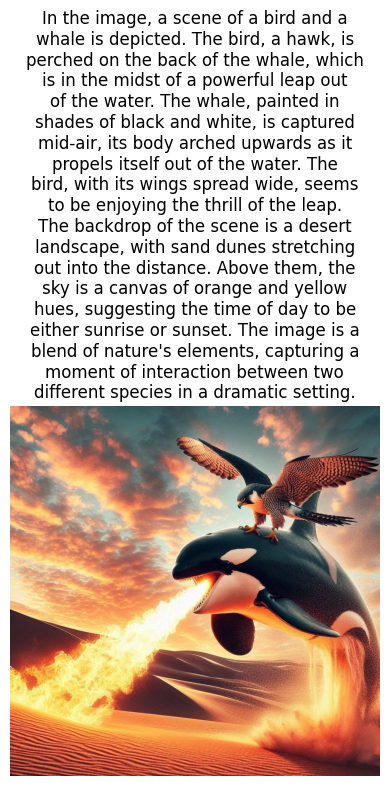

In [7]:
img_path = 'images/test3.jpg'
noVar = Image_desc(img_path, 'Deeply describe exverything in and that is happening in this image')

# loop through images for description

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


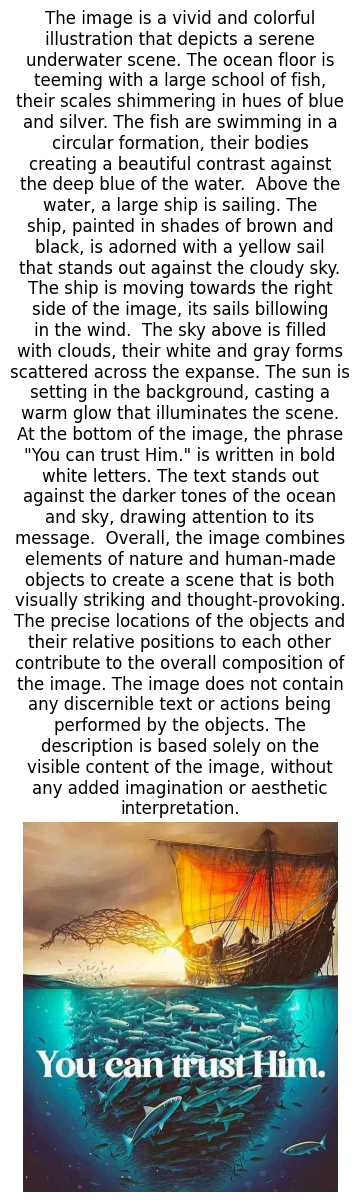

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


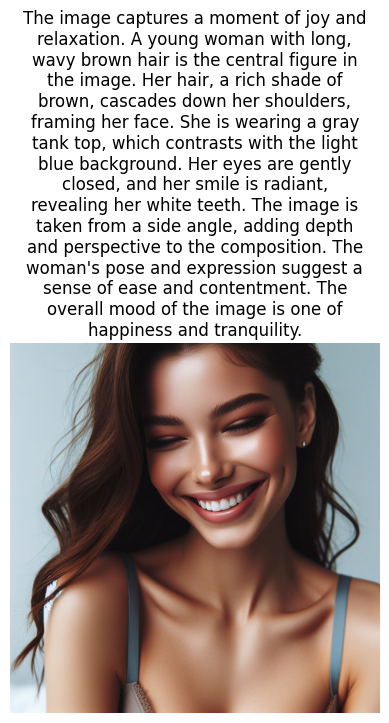

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


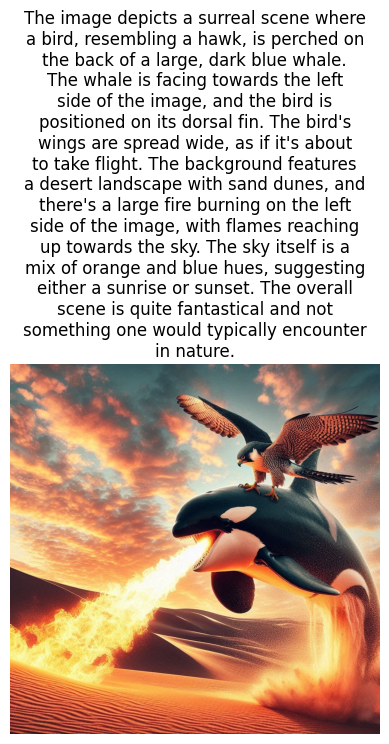

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


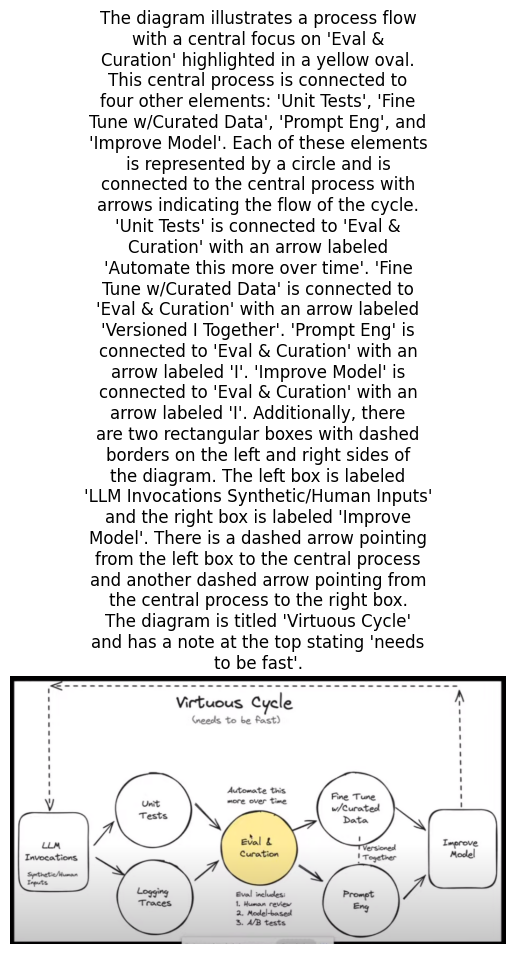

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


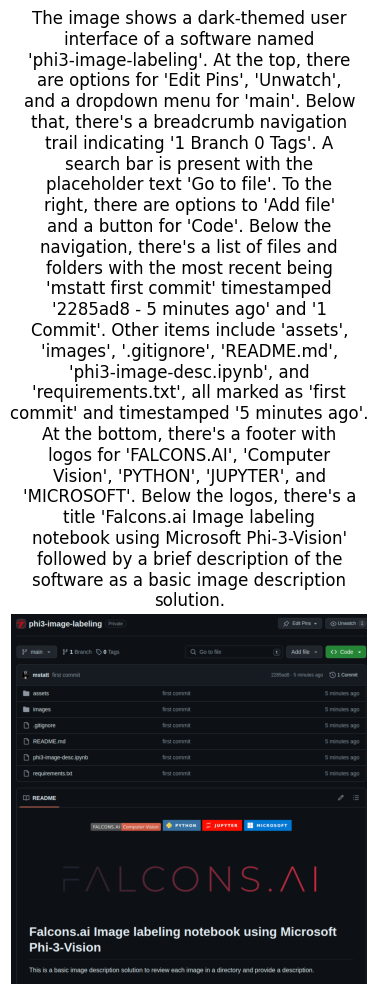

In [8]:
# Loop through the sorted list
for i in jpg_images:
    description = Image_desc(i)
    save_image_description(i, description)
    # Added the sleep function to prevent Cuda memory issues
    time.sleep(2)


## If you downloaded the model from Huggingface, and want to run it local going forward
Uncomment the code below to save the model

In [9]:
# # Define the path where you want to save the model and processor
# model_save_path = "./phi3"
# processor_save_path = "./phi3"
# model_id = "microsoft/Phi-3-vision-128k-instruct" 
# model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto", _attn_implementation='flash_attention_2') # use _attn_implementation='eager' to disable flash attention
# processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True) 

# # Save the model with safe serialization
# model.save_pretrained(model_save_path, safe_serialization=False)

# # Save the processor
# processor.save_pretrained(processor_save_path)


## Test the new Microsoft Florence Model which appears to be lighter on the resources.

https://huggingface.co/microsoft/Florence-2-base

In [10]:
def run_florence(img):
    model_id2 = "./florence"
    model = AutoModelForCausalLM.from_pretrained(model_id2, trust_remote_code=True)
    processor = AutoProcessor.from_pretrained(model_id2, trust_remote_code=True)

    prompt = "<MORE_DETAILED_CAPTION>"

    image = Image.open(img)

    # Ensure the image is in RGB format
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task="<MOST_DETAILED_CAPTION>", image_size=(image.width, image.height))

    del model
    del processor
    # Convert dict value to string
    strResponse = list(parsed_answer.values())[0]

    plt.imshow(image)
    wrapped_title = "\n".join(textwrap.wrap(strResponse, width=40))
    plt.title(wrapped_title)
    plt.axis('off')  # Hide the axis for better visualization
    plt.show()

    return strResponse


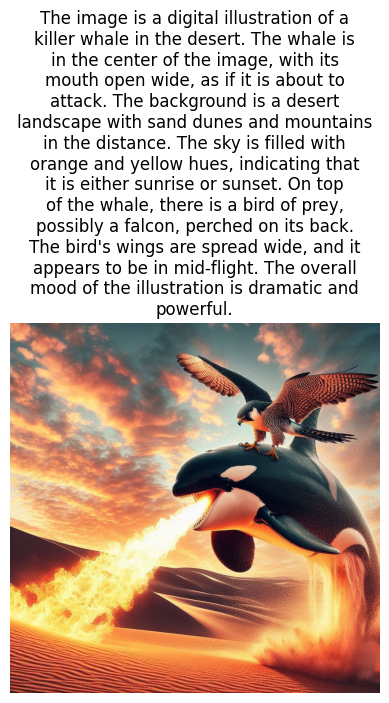

"The image is a digital illustration of a killer whale in the desert. The whale is in the center of the image, with its mouth open wide, as if it is about to attack. The background is a desert landscape with sand dunes and mountains in the distance. The sky is filled with orange and yellow hues, indicating that it is either sunrise or sunset. On top of the whale, there is a bird of prey, possibly a falcon, perched on its back. The bird's wings are spread wide, and it appears to be in mid-flight. The overall mood of the illustration is dramatic and powerful."

In [11]:
run_florence('./images/test3.jpg')

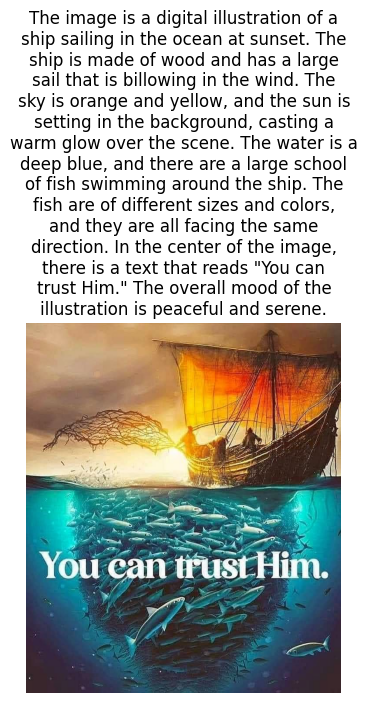

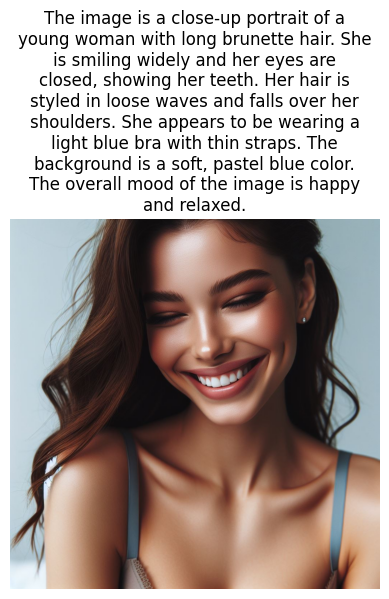

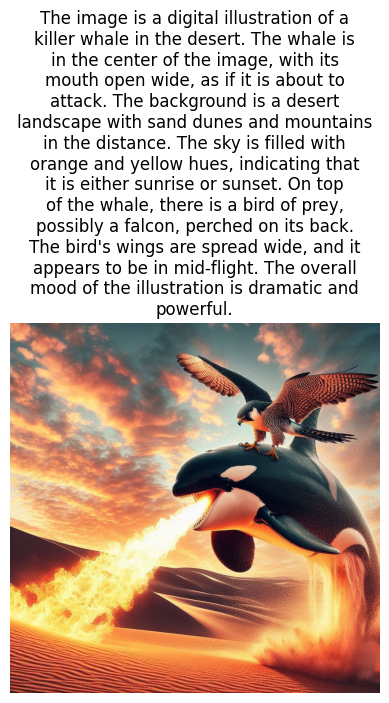

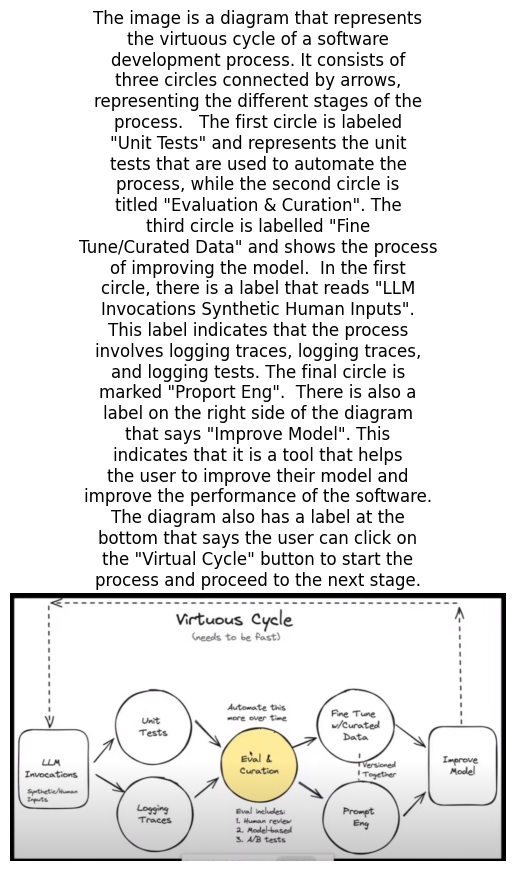

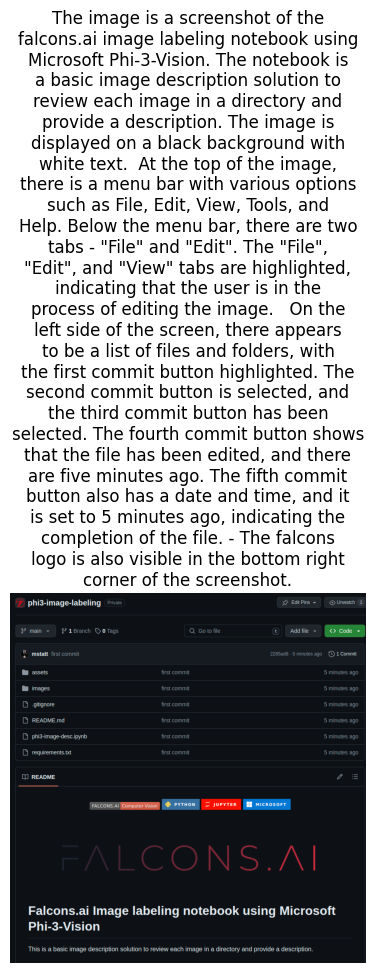

In [12]:
# Loop through the sorted list
for i in jpg_images:
    description = run_florence(i)
    save_image_description(i, description)
    # Added the sleep function to prevent Cuda memory issues
    time.sleep(2)

## Save the Florence Model

In [13]:
# # Define the path where you want to save the model and processor
# model_save_path = "./florence"
# processor_save_path = "./florence"
# model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)
# processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

# # Save the model with safe serialization
# model.save_pretrained(model_save_path, safe_serialization=False)

# # Save the processor
# processor.save_pretrained(processor_save_path)